In [9]:
import numpy as np
import pandas as pd
from collections import Counter

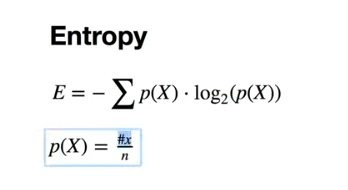

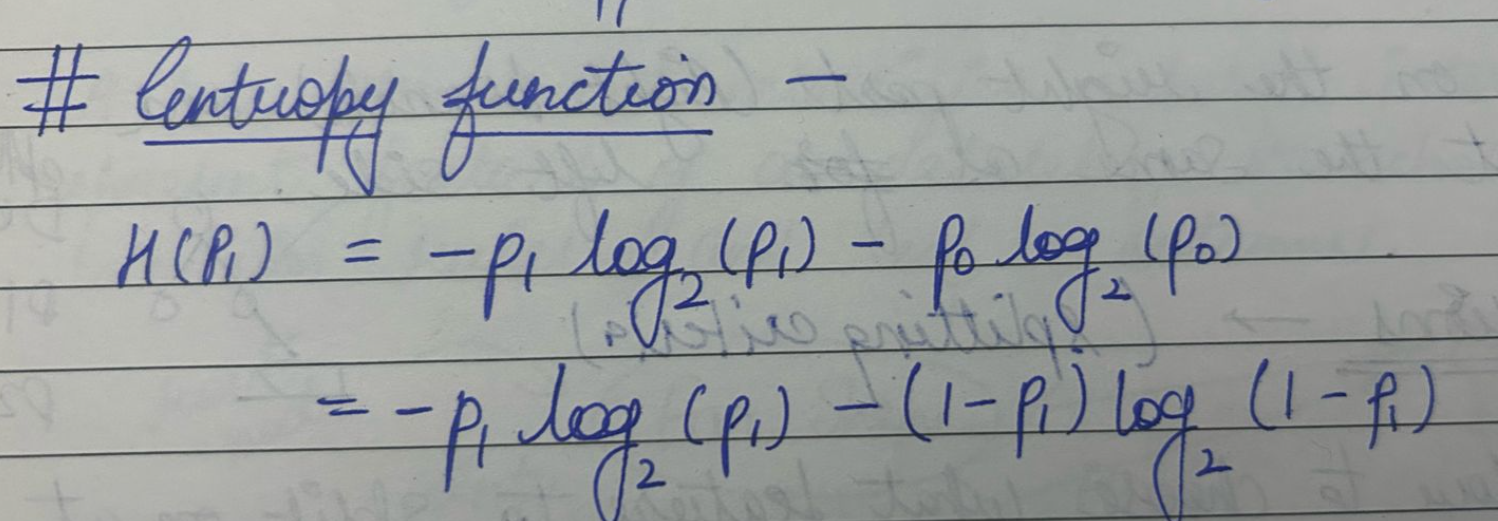

In [2]:
def entropy(y):
    hist = np.bincount(y) #  [0,0,0,0,0,0,0,1,1,1] -> array([7,3])
    ps = hist / len(y)    #  [0.7, 0.3]
    return  -np.sum([p * np.log2(p) for p in ps if p > 0])     


In [4]:
# y = [0,0,0,0,0,0,0,1,1,1]
# print(entropy(y))

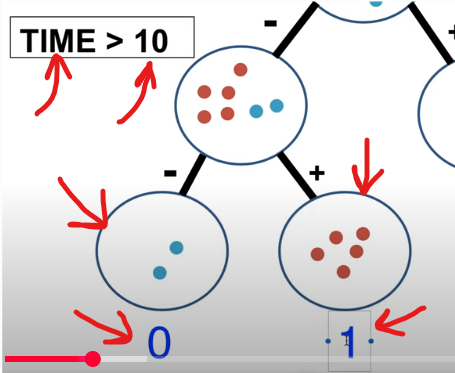

A node will need to store

- Feature on which to split
- Threshold
- left child
- Right Child
- Value is LEAF

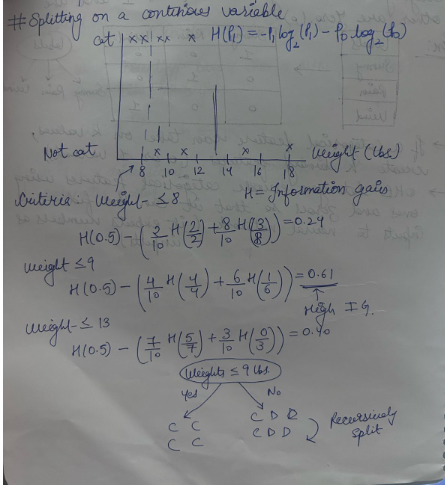

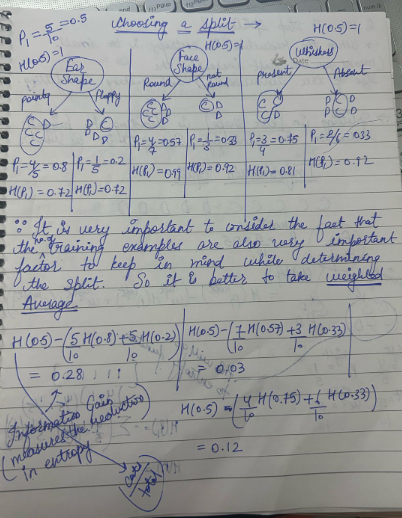

In [19]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, *, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None

In [24]:
# n_feats -> some k number of features k << n (features) only those to use for splits
class DecisionTree:
    def __init__(self, min_samples_split = 2, max_depth = 100, n_feats = None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        # grow tree 
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X,y)

    def _grow_tree(self, X, y, depth = 0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))  # 2 in case of [1,1,1,0,1,0,0,0,0] = no of class labels

        # Stopping criteria 
        if(depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split): 
            leaf_value = self._most_common_label(y)
            return Node(value = leaf_value) 
        
        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedy search 
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)


    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)


                if(gain > best_gain):
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # Parent entropy
        parent_entropy = entropy(y)
        # Generate Split 
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if(len(left_idxs) == 0 or len(right_idxs) == 0):
            return 0
        # Weighted avg. child E 
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        # return Info Gain
        info_gain = parent_entropy - child_entropy
        return info_gain
    

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
    
    # # y = [0,0,0,1,1,0,0,1]
    # counter = Counter(y)  
    # # Counter({0: 5, 1: 3})  # Shows 0 appears 5 times, 1 appears 3 times
    # counter.most_common(1)  
    # # [(0, 5)]  # Returns list with tuple of (value, count) for most common element
    # counter.most_common(1)[0]  
    # # (0, 5)  # Gets first tuple
    # counter.most_common(1)[0][0]  
    # # 0  # Gets just the value (not the count)  
    
    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common


    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if(x[node.feature] <= node.threshold):
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    


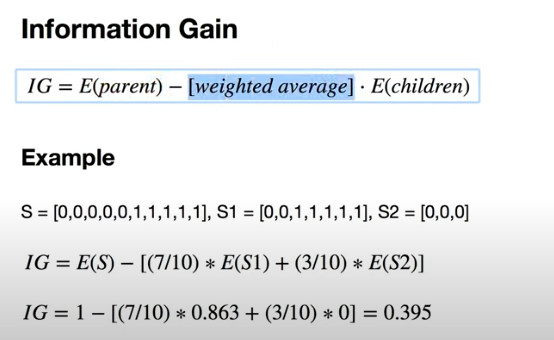

In [25]:
# if __name__ == "__main__":
#     # Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy:", acc)

Accuracy: 0.9210526315789473
